In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

This cell defines a helper function to load daily data for separate years and combine them into a single DataFrame, and then loads station metadata and merges it with the daily data.

In [37]:
def load_data(root, years=None):
    '''Helper to read and combine yearly data frames'''
    dfs = []
    years = years or range(1995, 2023)
    for year in years:
        file = f"{root}/daily/{year}-daily.csv"
        df = pd.read_csv(file, parse_dates=['date'])
        df = df[df['period']=='night']
        dfs.append(df)
    df = pd.concat(dfs)
    return df

# Path to data directory: edit if needed
root = "../data"

# Load daily data for all years
raw_df = load_data(root)

# Load station metadata and merge
station_df = pd.read_csv(f"{root}/meta/nexrad-stations.csv")
raw_df = raw_df.merge(station_df, left_on='station', right_on='callsign')


# Plot migration traffic

This cell shows and example of subselecting data for a couple stations and a specific time period, and plotting the daily migration traffic for those stations.

<Axes: title={'center': 'Migration traffic'}, xlabel='Date', ylabel='Traffic (cm$^2$ km$^{-1}$)'>

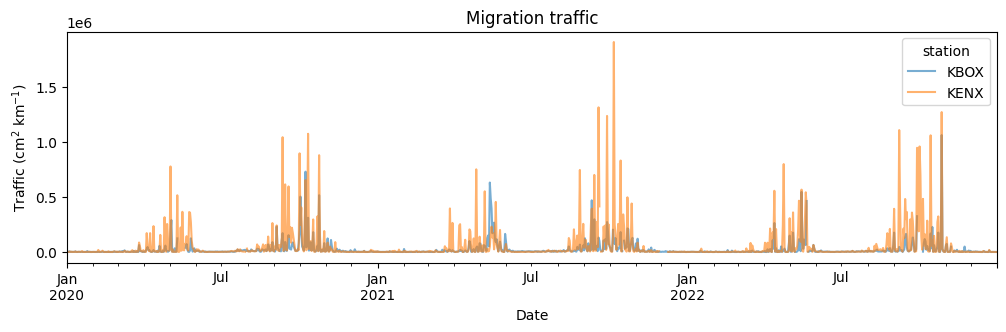

In [38]:
df = raw_df.copy()

# Select data to plot
df = df.query('station in ["KBOX", "KENX"] and date.dt.year >= 2020')

# Pivot to create separate columns for each station
df = df.pivot(index='date', columns='station', values='traffic')

# Plot
df.plot(figsize=(12,3), xlabel='Date', ylabel='Traffic (cm$^2$ km$^{-1}$)', title='Migration traffic', alpha=0.6)

# Plot phenology curves

This cell shows an example of plotting phenology curves for selected stations over a specified time period.

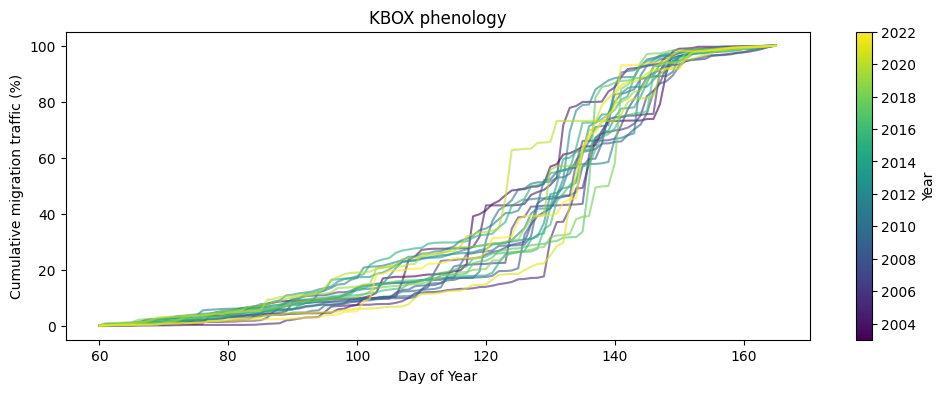

In [68]:
df = raw_df.copy()

# Select spring data from 1999 onwards
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.dayofyear
df = df.query('year >= 1999 and day >= 60 and day <= 165')

# Compute cumulative percent traffic within each station-year
df['traffic'] = df['traffic'].fillna(0)
cumulative_traffic = df.groupby(['year', 'station'])['traffic'].cumsum()
total_traffic = df.groupby(['year', 'station'])['traffic'].transform('sum')
df['percent_traffic'] = cumulative_traffic / total_traffic * 100

# Compute percent missing for each station-year
df['fraction_missing'] = df['fraction_missing'].fillna(1.0)
df['missing'] = df.groupby(['year', 'station'])['fraction_missing'].transform('mean')

# Drop if too many missing values
df = df.query('missing < 0.2') 

# Select data for single station and pivot to have years as columns
station='KBOX'
station_df = df.query(f'station == "{station}"').pivot(index='day', columns='year', values='percent_traffic')

# Create colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=station_df.columns.min(), vmax=station_df.columns.max())
# Plot each year with color corresponding to year
ax = station_df.plot(figsize=(12, 4), 
             colormap=cmap, 
             alpha=0.6, 
             legend=False, 
             xlabel='Day of Year', 
             ylabel='Cumulative migration traffic (%)', 
             title=f'{station} phenology')


# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, label='Year')
cbar.ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))


# Plot average migration traffic

Plot the average migration traffic across all years for a specific set of stations.

<Axes: title={'center': 'Average Migration Traffic (1995-2022)'}, xlabel='Day of Year', ylabel='Average Traffic (cm$^2$ km$^{-1}$)'>

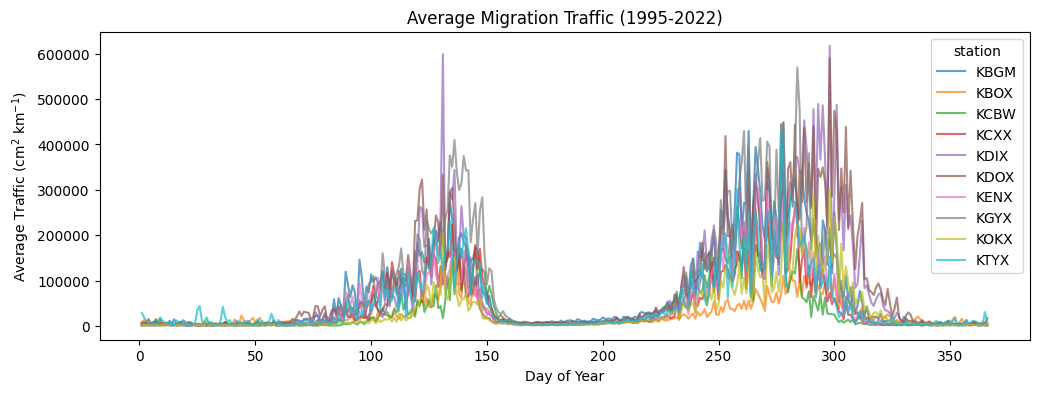

In [71]:
stations = ["KCBW", "KGYX", "KCXX", "KTYX", "KBGM", "KENX", "KBOX", "KOKX", "KDIX", "KDOX"]

# Compute average traffic per day of year for selected stations
df = raw_df.copy()
df['day'] = df['date'].dt.dayofyear
df = df.query(f'station in {stations}')
avg_df = df.groupby(['station', 'day'])['traffic'].mean().reset_index()

# Pivot to have stations as columns and plot
avg_df = avg_df.pivot(index='day', columns='station', values='traffic') 
avg_df.plot(figsize=(12,4), xlabel='Day of Year', ylabel='Average Traffic (cm$^2$ km$^{-1}$)', title='Average Migration Traffic (1995-2022)', alpha=0.7)   
